In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img=cv2.imread('dog.png')
img=cv2.resize(img, dsize=(640,480))

In [3]:
#We have to reorder the color channels used by cv2 in order to use
# plt.imshow properly.

def imshow(img):
    plt.imshow(img[:,:,::-1])

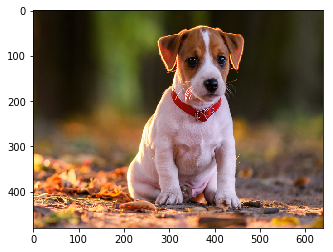

In [4]:
imshow(img)

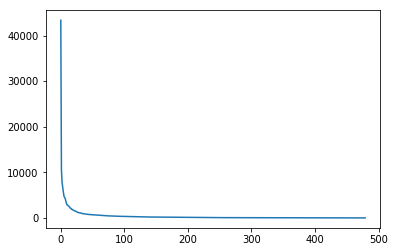

In [5]:
#Plot of the magnitude of the singular values, which are ordered by size, just to
# give us a notion of how many singular values we should keep. It's very clear that
# only the first few ones are really important.

_,s,_ = np.linalg.svd(img[:,:,0])

plt.plot(s)

In [6]:
#We compress the image img to the three arrays u, s and vh.

#To compress, we use the first "keep" terms corresponding to the most
# relevant singular values. In other words, we can store only the first "keep" columns of the matrices u
# the first "keep" rows of vh and the first "keep" entries of the vector s of singular values.

#Depending on "keep", this usually means less numbers to store than with the original image.
# But here is the catch: the original image is of type int. If we make svd, we have a float, which by
# default in numpy will take 64 bits. So, the amount of compression for discarding a lot of singular values might be
# surprisingly low. On the other hand, the effect of discarding least relevant decimals in the matrices u and vh
# is almost negligible since we are already discarding many singular values. So, we should use np.float16
# for a much better compression rate.

#Because of numpy's svd convention, we should use the first index of the image as the color channel, in order
# to apply svd in each channel independently. In order to do so, we swap axes.

#In the reconstruction, we should return the output in the same format of the original image: that is,
# an integer array, cropped at the [0,255] interval. We use numpy's apply_along_axis to make
# a 3D array, corresponding to the three 2D arrays of the singular values for each color channel,
# starting from the 2D array 's' which represents the vector of singular values for each color channel.

#Since we are operating with 3D arrays, each one with the first index representing a channel,
# np.matmul is the way to go.

def compress(img, keep=40):
    img_ = img.swapaxes(0,2)
    u,s,vh = np.linalg.svd(img_)
    u = u.astype(np.float16)
    vh = vh.astype(np.float16)
    return u[:,:,:keep], s[:,:keep], vh[:,:keep]

def reconstruct(u,s,vh):
    imgrec = np.matmul(np.matmul(u, np.apply_along_axis(np.diag, 1, s)), vh)
    imgrec = imgrec.swapaxes(0,2)
    imgrec = imgrec.astype(int)
    imgrec[imgrec > 255] = 255
    imgrec[imgrec < 0] = 0
    return imgrec

def compression_rate(img,u,s,vh):
    return (u.nbytes + s.nbytes + vh.nbytes) / img.nbytes

In [7]:
u,s,vh = compress(img,keep=60)

In [8]:
print("Image size is now {:.1%} of the original".format(compression_rate(img,u,s,vh)))

Image size is now 43.9% of the original


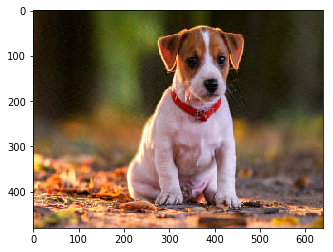

In [9]:
imgrec = reconstruct(u,s,vh)
imshow(imgrec)